<a href="https://colab.research.google.com/github/k-sidana-77/Clustering/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth


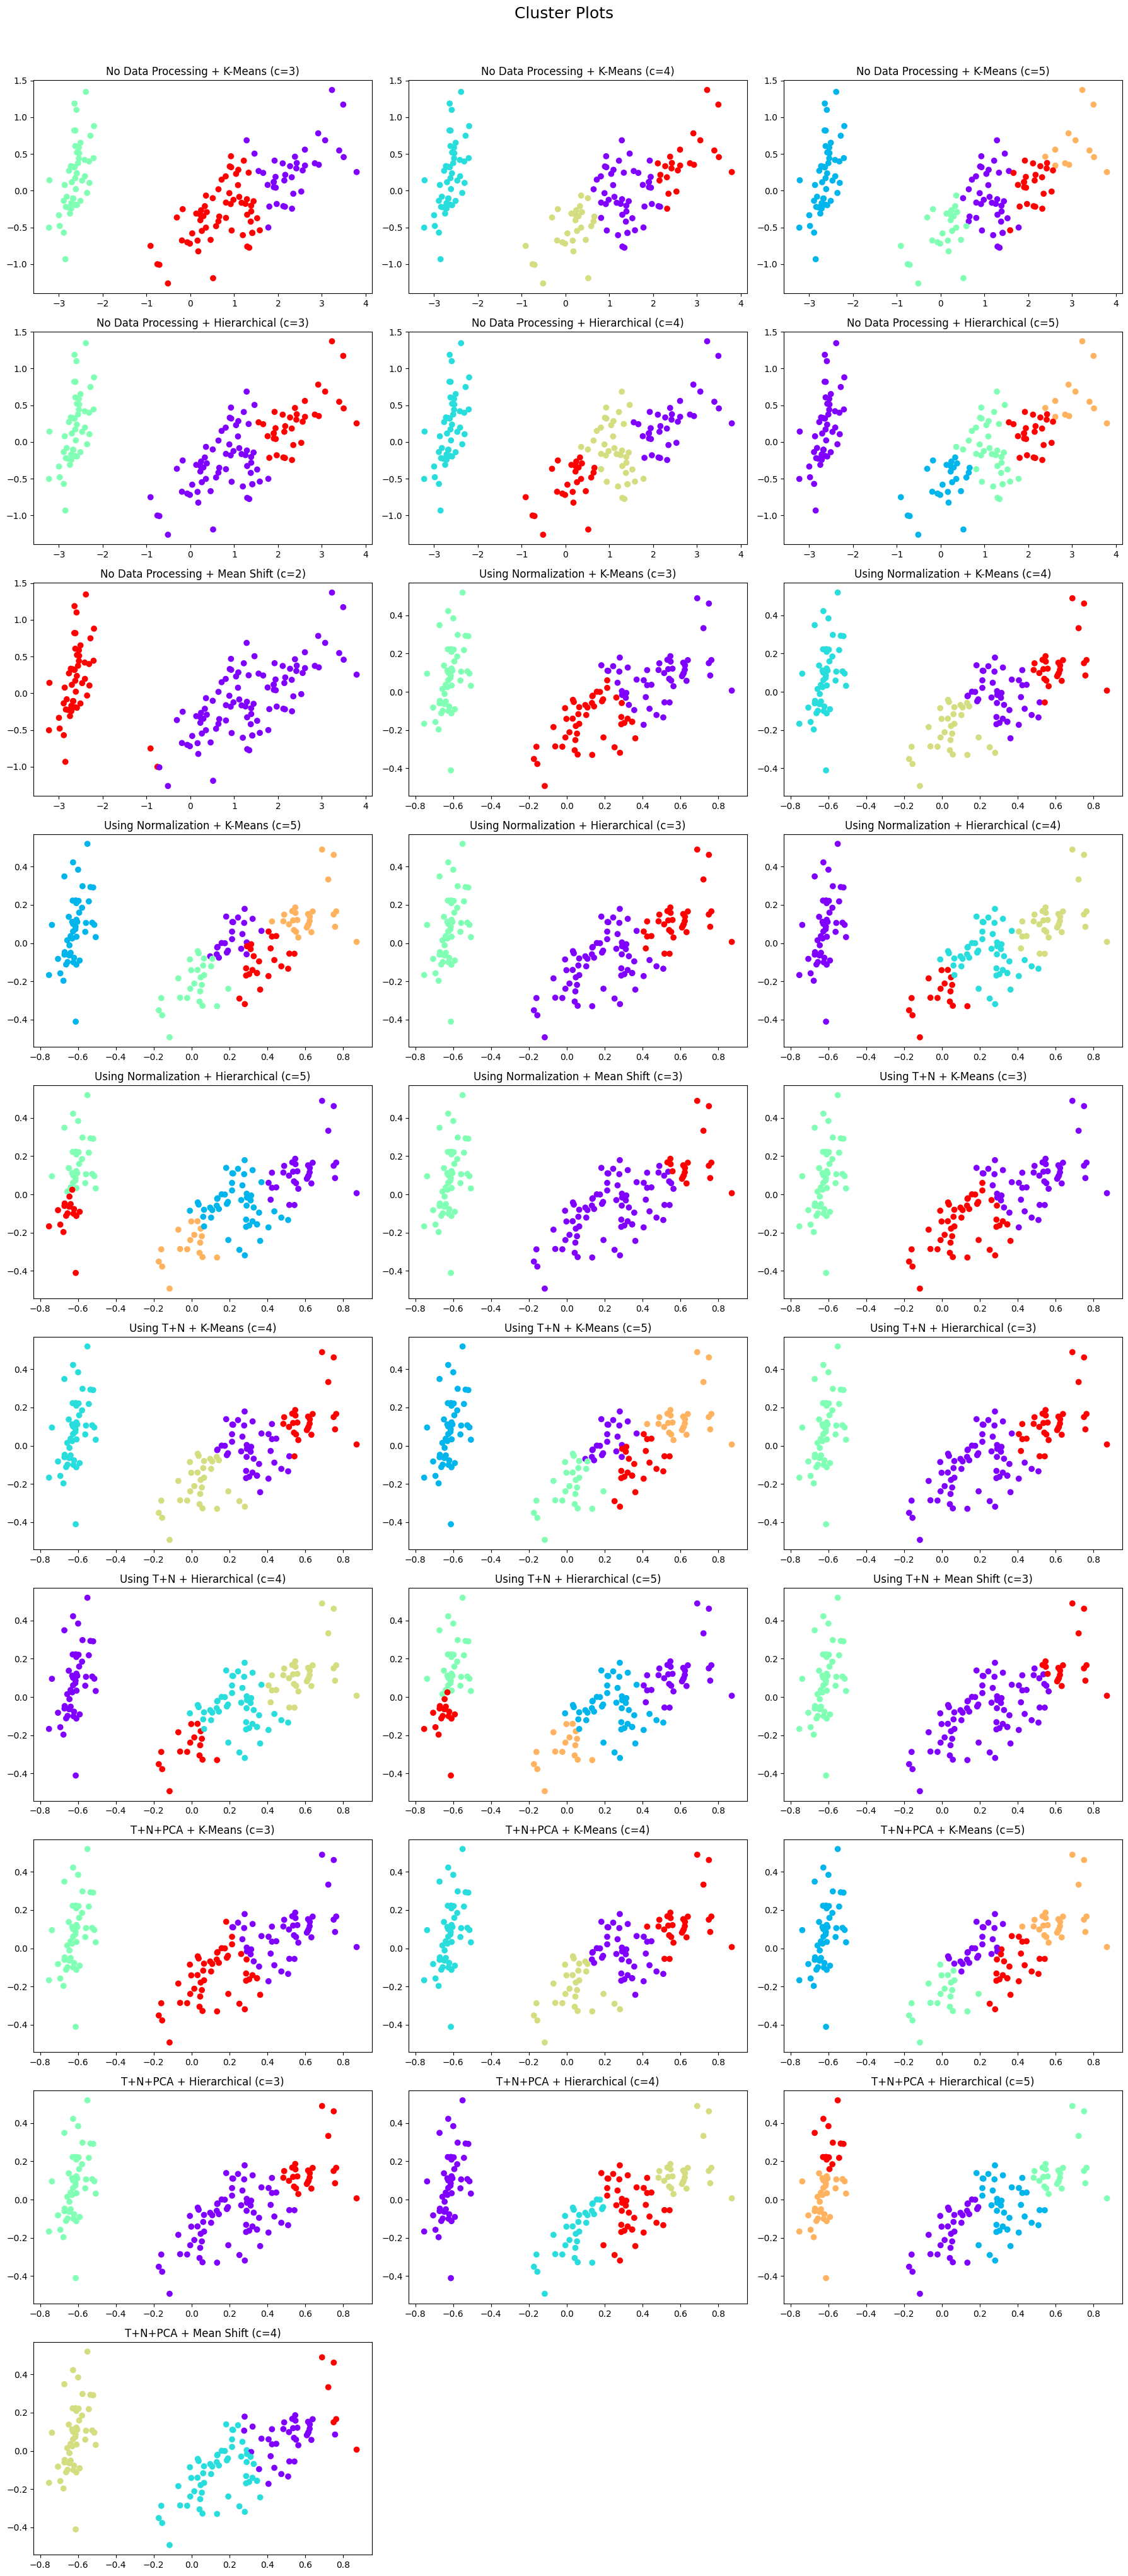

In [9]:
# Load Iris Dataset (.data format from UCI)
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
df = pd.read_csv('iris.data', header=None, names=column_names)

# Separate features and target
X_raw = df.drop(columns=['species'])

# Define Preprocessing Functions
def preprocess_none(X):
    return X

def preprocess_normalize(X):
    return MinMaxScaler().fit_transform(X)

def preprocess_transform_normalize(X):
    X_t = StandardScaler().fit_transform(X)
    return MinMaxScaler().fit_transform(X_t)

def preprocess_transform_normalize_pca(X):
    X_t = StandardScaler().fit_transform(X)
    X_n = MinMaxScaler().fit_transform(X_t)
    return PCA(n_components=2).fit_transform(X_n)

# Preprocessing Options
dict_preprocess = {
    'No Data Processing': preprocess_none,
    'Using Normalization': preprocess_normalize,
    'Using T+N': preprocess_transform_normalize,
    'T+N+PCA': preprocess_transform_normalize_pca
}

# Define Clustering Functions
def cluster_kmeans(X, k):
    return KMeans(n_clusters=k, random_state=42).fit_predict(X)

def cluster_hierarchical(X, k):
    return AgglomerativeClustering(n_clusters=k).fit_predict(X)

def cluster_meanshift(X, k=None):
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=len(X))
    return MeanShift(bandwidth=bandwidth).fit_predict(X)

# Clustering Options
dict_clustering = {
    'K-Means': cluster_kmeans,
    'Hierarchical': cluster_hierarchical,
    'Mean Shift': cluster_meanshift
}

# Run all combinations and evaluate
results = []
cluster_counts = [3, 4, 5]

# Determine total number of plots
total_plots = 0
for prep in dict_preprocess:
    for method in dict_clustering:
        total_plots += len(cluster_counts) if method != 'Mean Shift' else 1

cols = 3
rows = (total_plots + cols - 1) // cols
plt.figure(figsize=(cols * 6, rows * 4))
plot_index = 1

for prep_name, prep_func in dict_preprocess.items():
    X_preprocessed = prep_func(X_raw)
    X_plot = PCA(n_components=2).fit_transform(X_preprocessed) if X_preprocessed.shape[1] > 2 else X_preprocessed

    for cluster_name, cluster_func in dict_clustering.items():
        if cluster_name == 'Mean Shift':
            try:
                labels = cluster_func(X_preprocessed)
                k_used = len(np.unique(labels))
                silhouette = silhouette_score(X_preprocessed, labels)
                calinski = calinski_harabasz_score(X_preprocessed, labels)
                davies = davies_bouldin_score(X_preprocessed, labels)

                results.append({
                    'Preprocessing': prep_name,
                    'Clustering': cluster_name,
                    'Clusters': k_used,
                    'Silhouette': silhouette,
                    'Calinski-Harabasz': calinski,
                    'Davies-Bouldin': davies
                })

                plt.subplot(rows, cols, plot_index)
                plt.scatter(X_plot[:, 0], X_plot[:, 1], c=labels, cmap='rainbow')
                plt.title(f"{prep_name} + {cluster_name} (c={k_used})")
                plot_index += 1
            except Exception as e:
                print(f"Error with {prep_name}, {cluster_name}: {e}")
        else:
            for k in cluster_counts:
                try:
                    labels = cluster_func(X_preprocessed, k)
                    silhouette = silhouette_score(X_preprocessed, labels)
                    calinski = calinski_harabasz_score(X_preprocessed, labels)
                    davies = davies_bouldin_score(X_preprocessed, labels)

                    results.append({
                        'Preprocessing': prep_name,
                        'Clustering': cluster_name,
                        'Clusters': k,
                        'Silhouette': silhouette,
                        'Calinski-Harabasz': calinski,
                        'Davies-Bouldin': davies
                    })

                    plt.subplot(rows, cols, plot_index)
                    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=labels, cmap='rainbow')
                    plt.title(f"{prep_name} + {cluster_name} (c={k})")
                    plot_index += 1
                except Exception as e:
                    print(f"Error with {prep_name}, {cluster_name}, k={k}: {e}")

plt.tight_layout()
plt.suptitle("Cluster Plots", fontsize=18, y=1.02)
plt.savefig("cluster_plots.png", bbox_inches='tight')
plt.show()


In [10]:
# Create DataFrame of Results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Silhouette', ascending=False))

# Optional: Save raw results to CSV
results_df.to_csv('iris_clustering_results.csv', index=False)

# Format result tables like the sample image
def format_table_for_algorithm(results_df, algorithm_name):
    filtered = results_df[results_df['Clustering'] == algorithm_name]
    table = {}

    for metric in ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']:
        metric_row = {}
        for _, row in filtered.iterrows():
            col_label = f"{row['Preprocessing']} (c={row['Clusters']})"
            metric_row[col_label] = round(row[metric], 2)
        table[metric] = metric_row

    return pd.DataFrame(table).T

# Generate formatted tables
kmeans_table = format_table_for_algorithm(results_df, 'K-Means')
hierarchical_table = format_table_for_algorithm(results_df, 'Hierarchical')
meanshift_table = format_table_for_algorithm(results_df, 'Mean Shift')

# Display formatted tables
print("\n=== K-Means Clustering ===")
print(kmeans_table.to_string())

print("\n=== Hierarchical Clustering ===")
print(hierarchical_table.to_string())

print("\n=== Mean Shift Clustering ===")
print(meanshift_table.to_string())


          Preprocessing    Clustering  Clusters  Silhouette  \
6    No Data Processing    Mean Shift         2    0.682999   
3    No Data Processing  Hierarchical         3    0.554097   
24              T+N+PCA  Hierarchical         3    0.553435   
0    No Data Processing       K-Means         3    0.550964   
21              T+N+PCA       K-Means         3    0.538037   
22              T+N+PCA       K-Means         4    0.526889   
25              T+N+PCA  Hierarchical         4    0.510435   
23              T+N+PCA       K-Means         5    0.505461   
17            Using T+N  Hierarchical         3    0.504349   
10  Using Normalization  Hierarchical         3    0.504349   
27              T+N+PCA    Mean Shift         4    0.500898   
1    No Data Processing       K-Means         4    0.497412   
4    No Data Processing  Hierarchical         4    0.488740   
2    No Data Processing       K-Means         5    0.488518   
5    No Data Processing  Hierarchical         5    0.48

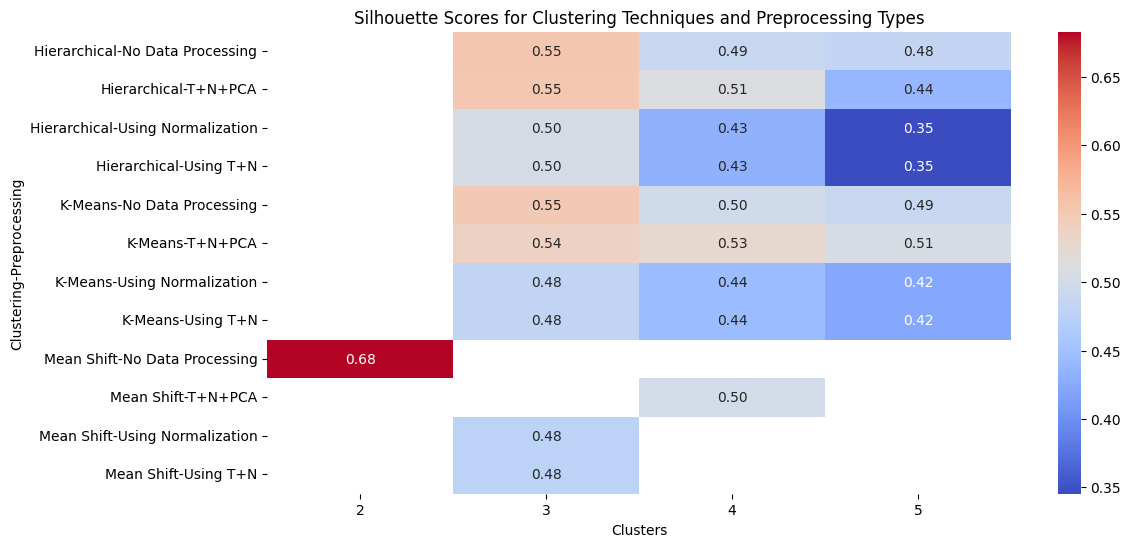

In [11]:
#Export formatted tables to Excel
with pd.ExcelWriter('formatted_clustering_tables.xlsx') as writer:
    kmeans_table.to_excel(writer, sheet_name='KMeans')
    hierarchical_table.to_excel(writer, sheet_name='Hierarchical')
    meanshift_table.to_excel(writer, sheet_name='MeanShift')

#Heatmap of Silhouette Scores
pivot_table = results_df.pivot_table(index=['Clustering', 'Preprocessing'], columns='Clusters', values='Silhouette')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Silhouette Scores for Clustering Techniques and Preprocessing Types')
plt.savefig("silhouette_heatmap.png", bbox_inches='tight')
plt.show()
